# Requirements

In [36]:
# Add as many imports as you need.
from datasets import load_dataset, DatasetDict, Dataset

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [38]:
# Write your code here. Add as many boxes as you need.
dataset = load_dataset("csv", data_files="data/wine-reviews.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['description', 'points'],
        num_rows: 10000
    })
})

## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [39]:
# Write your code here. Add as many boxes as you need.
df = dataset["train"].to_pandas()
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


In [40]:
df['exceptional'] = (df['points'] >= 90).astype(int)
df

,description,points,exceptional
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [41]:
df.drop(columns=['points'], axis=0, inplace=True)
df = df.head(1000)

In [42]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(df)
dataset

DatasetDict({
    train: Dataset({
        features: ['description', 'exceptional'],
        num_rows: 1000
    })
})

In [43]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["exceptional"])

In [44]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("exceptional")
dataset = dataset.rename_column("description", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [45]:
# Write your code here. Add as many boxes as you need.
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [46]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoTokenizer
checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [47]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [48]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3315.01 examples/s]


## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [49]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the traning parameters using the `TrainingArguments` class.

In [50]:
# Write your code here. Add as many boxes as you need.
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # report_to="none",
)

In [51]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [52]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [53]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

Define the training using the `Trainer` class.

In [54]:
# Write your code here. Add as many boxes as you need.
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Fine-tune (train) the pre-trained lanugage model.

In [55]:
# Write your code here. Add as many boxes as you need.
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.549380,0.749624


TrainOutput(global_step=100, training_loss=0.6084893035888672, metrics={'train_runtime': 890.6894, 'train_samples_per_second': 0.898, 'train_steps_per_second': 0.112, 'total_flos': 34919770378560.0, 'train_loss': 0.6084893035888672, 'epoch': 1.0})

In [56]:
trainer.evaluate()

{'eval_loss': 0.5493801832199097,
 'eval_f1': 0.7496240601503759,
 'eval_runtime': 52.5949,
 'eval_samples_per_second': 3.803,
 'eval_steps_per_second': 0.475,
 'epoch': 1.0}

Use the trained model to make predictions for the test set.

In [57]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_dataset["test"])

In [58]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [59]:
# Write your code here. Add as many boxes as you need.
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74        98
           1       0.74      0.78      0.76       102

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



Text(0.5, 1.0, 'Confusion Matrix')

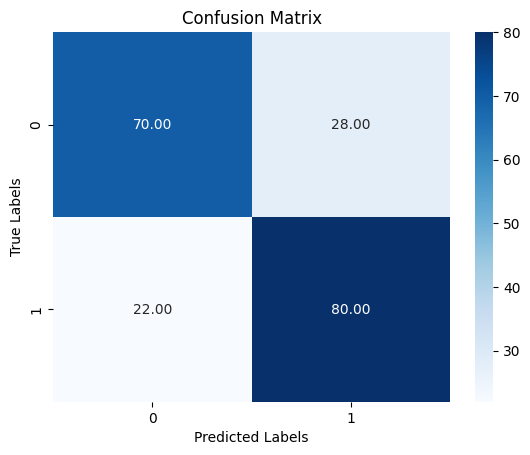

In [60]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [61]:
# Write your code here. Add as many boxes as you need.
df

,description,exceptional
0,"Translucent in color, silky in the mouth, this...",0
1,"On the palate, this wine is rich and complex, ...",1
2,The producer blends 57% Chardonnay from the Ma...,1
3,"Pure Baga in all its glory, packed with dry an...",1
4,Think of Subsídio as a contribution rather tha...,0
...,...,...
995,Smashed blackberry and blueberry fruit are enh...,1
996,There are extreme amounts of citrus on the nos...,0
997,"In the dry style of Blin Champagnes, this is a...",1
998,Extra time in bottle has proved rewarding for ...,1


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['description'],  df['exceptional'], test_size=0.2)

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [65]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.57      0.91      0.70      0.72      0.51       108
          1       0.65      0.91      0.57      0.76      0.72      0.54        92

avg / total       0.78      0.73      0.76      0.72      0.72      0.52       200



In [66]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [67]:
print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.69      0.87      0.77      0.78      0.59       108
          1       0.71      0.87      0.69      0.78      0.78      0.61        92

avg / total       0.79      0.78      0.79      0.77      0.78      0.60       200



# Невронска мрежа

In [185]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [186]:
df = pd.read_csv("data/wine-reviews.csv")
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


In [187]:
df['exceptional'] = (df['points'] >= 90).astype(int)
df

,description,points,exceptional
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [188]:
df.drop(columns=['points'], axis=0, inplace=True)
df = df.head(1000)

In [189]:
df

,description,exceptional
0,"Translucent in color, silky in the mouth, this...",0
1,"On the palate, this wine is rich and complex, ...",1
2,The producer blends 57% Chardonnay from the Ma...,1
3,"Pure Baga in all its glory, packed with dry an...",1
4,Think of Subsídio as a contribution rather tha...,0
...,...,...
995,Smashed blackberry and blueberry fruit are enh...,1
996,There are extreme amounts of citrus on the nos...,0
997,"In the dry style of Blin Champagnes, this is a...",1
998,Extra time in bottle has proved rewarding for ...,1


<Axes: xlabel='exceptional'>

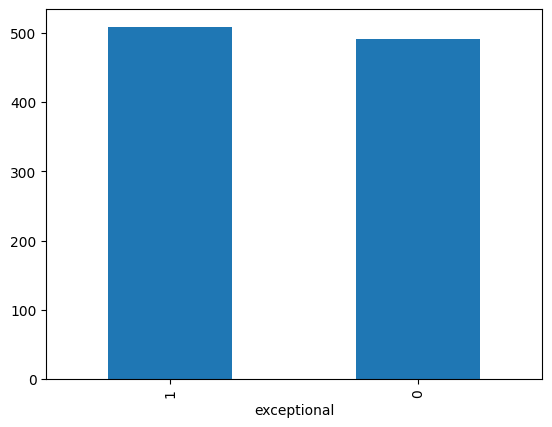

In [190]:
df["exceptional"].value_counts().plot.bar()

<Axes: ylabel='Frequency'>

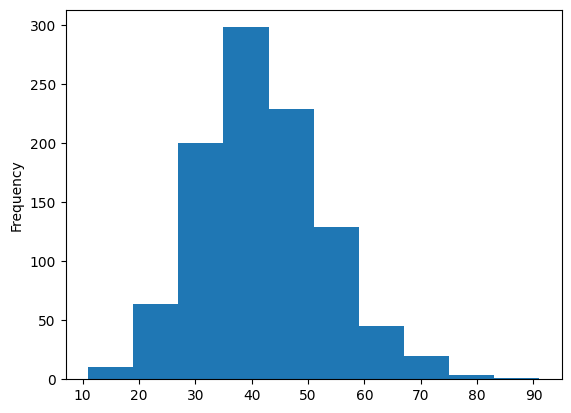

In [191]:
df["description"].str.split(" ").apply(len).plot.hist()

<Axes: >

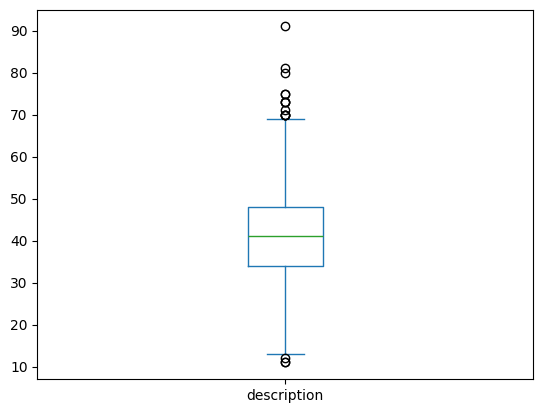

In [192]:
df["description"].str.split().apply(len).plot.box()

In [193]:
df = df[df["description"].str.split().apply(len) < 70].copy(deep=True)
df

,description,exceptional
0,"Translucent in color, silky in the mouth, this...",0
1,"On the palate, this wine is rich and complex, ...",1
2,The producer blends 57% Chardonnay from the Ma...,1
3,"Pure Baga in all its glory, packed with dry an...",1
4,Think of Subsídio as a contribution rather tha...,0
...,...,...
995,Smashed blackberry and blueberry fruit are enh...,1
996,There are extreme amounts of citrus on the nos...,0
997,"In the dry style of Blin Champagnes, this is a...",1
998,Extra time in bottle has proved rewarding for ...,1


<Axes: >

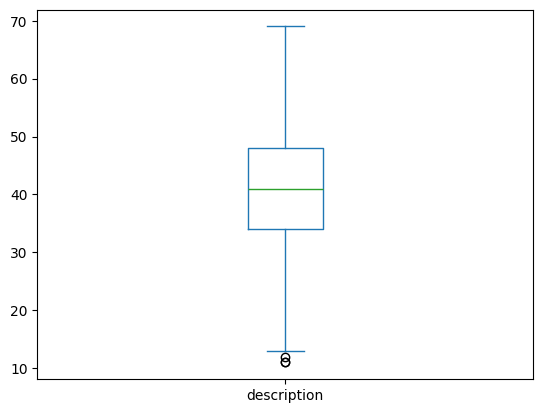

In [194]:
df["description"].str.split().apply(len).plot.box()

In [195]:
df = df[df["description"].str.split().apply(len) > 13].copy(deep=True)
df

,description,exceptional
0,"Translucent in color, silky in the mouth, this...",0
1,"On the palate, this wine is rich and complex, ...",1
2,The producer blends 57% Chardonnay from the Ma...,1
3,"Pure Baga in all its glory, packed with dry an...",1
4,Think of Subsídio as a contribution rather tha...,0
...,...,...
995,Smashed blackberry and blueberry fruit are enh...,1
996,There are extreme amounts of citrus on the nos...,0
997,"In the dry style of Blin Champagnes, this is a...",1
998,Extra time in bottle has proved rewarding for ...,1


<Axes: >

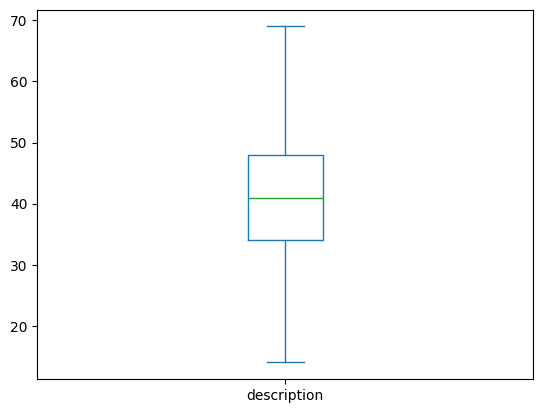

In [196]:
df["description"].str.split().apply(len).plot.box()

In [197]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [198]:
vocabulary = get_vocabulary(df["description"].tolist())

In [199]:
len(vocabulary)

6592

In [200]:
max_vocabulary_size = 6000

In [201]:
X, y = df["description"], pd.get_dummies(df["exceptional"])

In [202]:
num_classes = y.shape[1]
num_classes

2

In [203]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [204]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

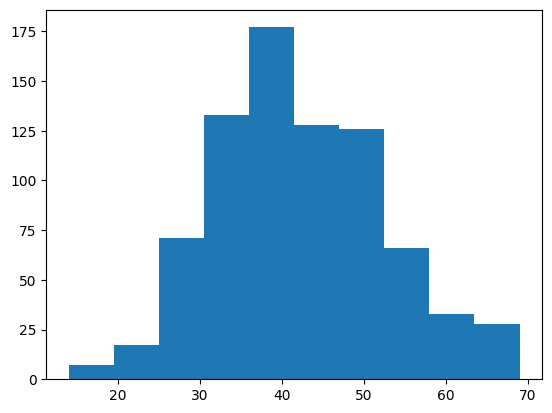

In [205]:
plt.hist([len(tokens) for tokens in train_X]);

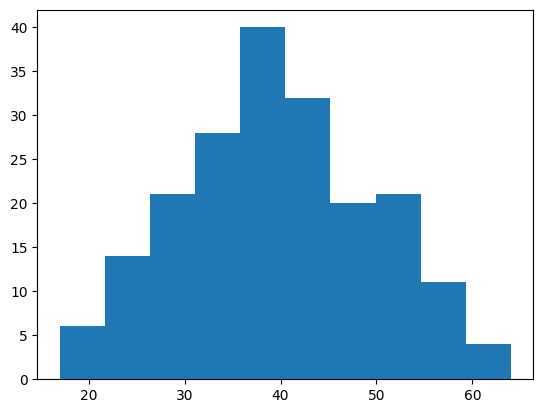

In [206]:
plt.hist([len(tokens) for tokens in test_X]);

In [207]:
maxlen = 60

In [208]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [209]:
train_X.shape, test_X.shape

((786, 60), (197, 60))

In [210]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="sigmoid")
])

In [211]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [212]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - f1_score: 0.3924 - loss: 0.6932 - precision: 0.4921 - recall: 0.6500 - val_f1_score: 0.3361 - val_loss: 0.6924 - val_precision: 0.5063 - val_recall: 0.5063
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - f1_score: 0.3465 - loss: 0.6900 - precision: 0.5308 - recall: 0.5308 - val_f1_score: 0.3361 - val_loss: 0.6901 - val_precision: 0.5063 - val_recall: 0.5063
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - f1_score: 0.3476 - loss: 0.6794 - precision: 0.5313 - recall: 0.5308 - val_f1_score: 0.4163 - val_loss: 0.6647 - val_precision: 0.5519 - val_recall: 0.5380
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - f1_score: 0.6712 - loss: 0.6049 - precision: 0.7094 - recall: 0.6748 - val_f1_score: 0.7058 - val_loss: 0.6160 - val_precision: 0.7078 - val_recall: 0.6899
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - f1_score: 0.8008 - loss: 0.4909 - precision: 0.8023 - recall: 0.7939 - val_f1_score: 0.7041 - val_loss: 0.5831 - v

In [213]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 60, 32)              │         192,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 60, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 30, 16)              │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 15, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657,176 (2.51 MB)

 Trainable params: 219,058 (855.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 438,118 (1.67 MB)

<Axes: >

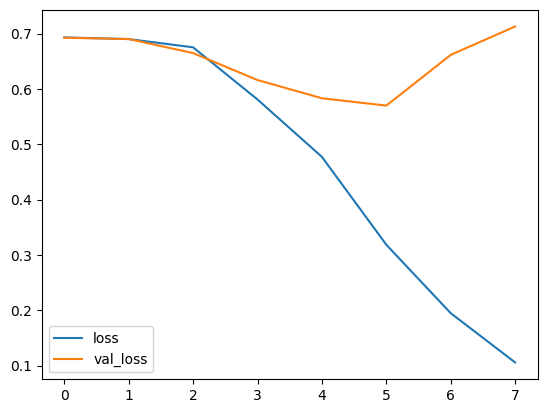

In [214]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [215]:
preds = model.predict(test_X)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


In [216]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [217]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       103
           1       0.81      0.67      0.73        94

    accuracy                           0.77       197
   macro avg       0.77      0.76      0.76       197
weighted avg       0.77      0.77      0.76       197



Text(0.5, 1.0, 'Confusion Matrix')

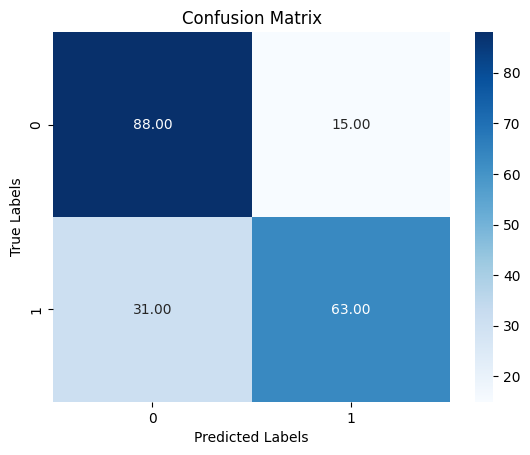

In [218]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")